# Ran 3 stages with more epochs. Experimenting with Google dataset.

Ok, so this will be my attempt at doing everything I learnt in Lesson 1 and perhaps Lesson 2.
Note to self: type everything out, no copy paste.

### Prediction problem I'm trying to solve: Given a facial photo, can AI tell me how I'm feeling in that.

First include essential instructions and libraries.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

Setting batch size to 64 for now. If you run out of memory, set to 16

In [3]:
bs=64

Prepare the directory structure and classes for creating and training the model and testing it as well.

In [4]:
#create primary path to save the model
path = Path('data/emotions')
#create 2d list to save filenames etc
folderfilearray = [('happy', 'urls_happy.txt'),('sad', 'urls_sad.txt'),('angry', 'urls_angry.txt')]
#create classes. this will remain common across training and test
classes = []
for i in range(len(folderfilearray)):
    classes.append(folderfilearray[i][0])
#print stuff to verify
print(path)
print(classes)

data/emotions
['happy', 'sad', 'angry']


# KDEF Dataset - Running e2e on this first.

## Download / Prepare dataset

In [5]:
#set training path
trainingpath = path/'kdef'
print(trainingpath)

data/emotions/kdef


Images are already downloaded into specific folders under the training path. Only need to verify them.

In [6]:
for i in range(len(folderfilearray)):
    dest = trainingpath/classes[i]
    print("Destination folder set to", dest)
    print("\nVerifying images now..")
    verify_images(dest, delete=True, max_workers=8)

Destination folder set to data/emotions/kdef/happy

Verifying images now..


Destination folder set to data/emotions/kdef/sad

Verifying images now..


Destination folder set to data/emotions/kdef/angry

Verifying images now..


Creating image databunch on this dataset now...

In [6]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train="./kdef", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['angry', 'happy', 'sad'], 3, 1652, 447)

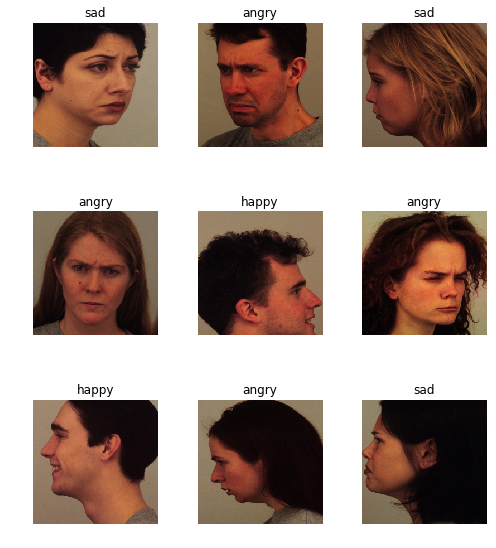

In [9]:
data.show_batch(rows=3, figsize=(7,8))

## Train model on kdef dataset

In [8]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [11]:
learn.fit_one_cycle(8)

Total time: 02:01
epoch  train_loss  valid_loss  error_rate
1      1.291404    0.903586    0.431767    (00:18)
2      1.081998    0.748064    0.342282    (00:14)
3      0.923744    0.624879    0.279642    (00:14)
4      0.774474    0.537242    0.230425    (00:14)
5      0.648245    0.481308    0.208054    (00:14)
6      0.560740    0.430545    0.190157    (00:14)
7      0.499450    0.423226    0.194631    (00:14)
8      0.460942    0.419168    0.187919    (00:14)



In [12]:
#learn.save('stage-1')
learn.save('stage-4')

First stage done and saved. Now let us try to improve it.

In [13]:
learn.unfreeze()
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


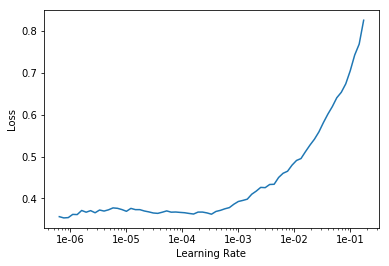

In [14]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(4, max_lr=slice(5e-7,5e-4))

Total time: 01:02
epoch  train_loss  valid_loss  error_rate
1      0.385522    0.388940    0.176734    (00:15)
2      0.347820    0.340376    0.156600    (00:15)
3      0.328185    0.312772    0.140940    (00:16)
4      0.304906    0.309570    0.136465    (00:15)



In [16]:
#learn.save('stage-2')
learn.save('stage-5')

### Unfreeze and retrain multiple times with different epochs and learning rates. No need to do this if earlier stages yielded low error rates. Just save and load that stage later.

In [21]:
learn.unfreeze()
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


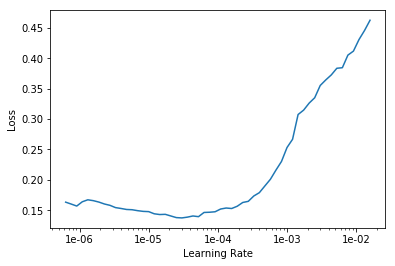

In [22]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,5e-5))

Total time: 02:03
epoch  train_loss  valid_loss  error_rate
1      0.145500    0.223357    0.093960    (00:15)
2      0.145722    0.214449    0.089485    (00:15)
3      0.135712    0.206974    0.087248    (00:15)
4      0.133099    0.209662    0.082774    (00:16)
5      0.132319    0.208158    0.085011    (00:15)
6      0.121070    0.203358    0.078300    (00:14)
7      0.114681    0.203697    0.076063    (00:15)
8      0.114322    0.204158    0.078300    (00:15)



In [24]:
#learn.save('stage-3')
#learn.save('stage-6')
learn.save('stage-7')

## Interpret results from KDEF dataset

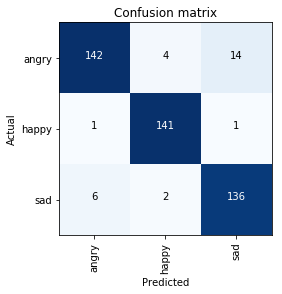

In [9]:
learn.load('stage-3')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [26]:
interp.most_confused(min_val=2)

[('angry', 'sad', 14), ('sad', 'angry', 6), ('angry', 'happy', 4)]

So after stage 3, the model has a 6% error rate and is mostly confused between angry and sad. Let's view the images to see if its confusing to us too.

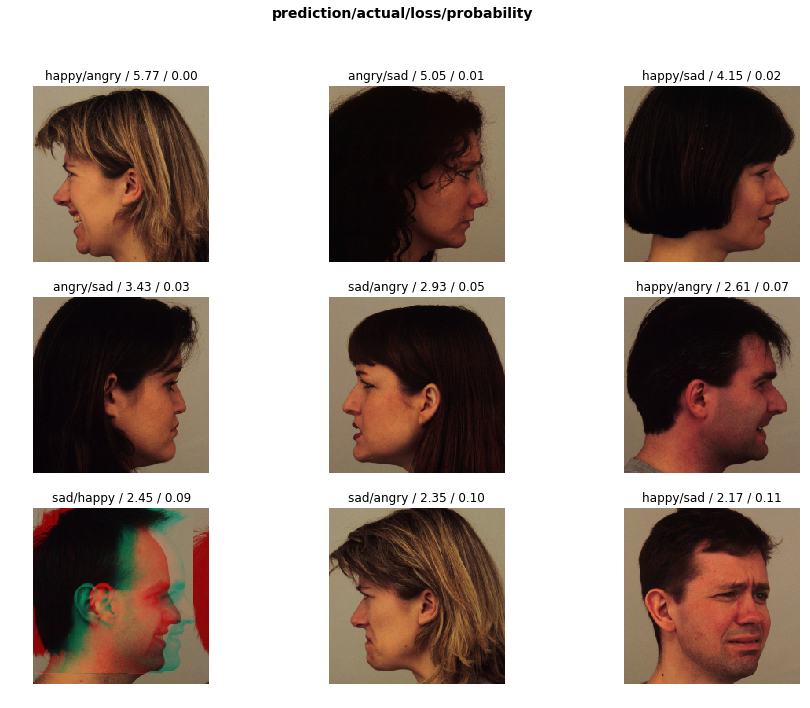

In [27]:
interp.plot_top_losses(9, figsize=(15,11))

Going to apply this model on the dataset downloaded from Google image search of the phrases "human face angry/happy/sad" and see how it performs.

# Testing the model using Dataset from Google Search

Ok, so I'm going to attempt to create a second dataset from Google images and run the trained model on those. Similar to how Lesson 2 does it for one image (Production example) but I want to do it over an entire dataset.

In [10]:
print(path)
testpath = Path(path/'googledata')
print(testpath)

data/emotions
data/emotions/googledata


In [29]:
for i in range(len(folderfilearray)):
    folder = folderfilearray[i][0]
    dest = testpath/folder
    dest.mkdir(parents=True, exist_ok=True)

Great. That should create three folders under our test directory called 'googleset', one per class, so we can store our images in them. Time to upload the url files to the path directory and then run script to read urls file and download images to specific folders.

Classes already created for training set. Using same classes for test set. Verify via print.

In [30]:
print(classes)

['happy', 'sad', 'angry']


Now, run through all classes to download images from urls file to dest folder. Let's get 70 pics of each kind for now. Then clean up to remove images we cant open in each folder. Then manually prune. Hopefully we have at least 50 good pictures by the end.

In [31]:
for i in range(len(folderfilearray)):
    file = folderfilearray[i][1]
    dest = testpath/classes[i]
    print("\nReading urls from", file)
    print("Destination folder set to", dest)
    print("\nDownloading images now..")
    #download_images(testpath/file, dest, max_pics=70)
    print("\nVerifying images now..")
    #verify_images(dest, delete=True, max_workers=8)


Reading urls from urls_happy.txt
Destination folder set to data/emotions/googledata/happy


Verifying images now..

Reading urls from urls_sad.txt
Destination folder set to data/emotions/googledata/sad


Verifying images now..

Reading urls from urls_angry.txt
Destination folder set to data/emotions/googledata/angry


Verifying images now..


## Create DataBunch passing this dataset as the test folder.

In [56]:
doc(ImageDataBunch.from_folder)

In [11]:
print(path)
print(testpath)

data/emotions
data/emotions/googledata


In [44]:
np.random.seed(42) #ensures validation set remains same in every run

### First testing this out with 3 images saved directly in testpath.

In [61]:
testData = ImageDataBunch.from_folder(path, train="./kdef", test="./googledata", valid_pct=0.2, 
                                      ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [62]:
testData.classes, testData.c, len(testData.train_ds), len(testData.valid_ds), len(testData.test_ds)

(['angry', 'happy', 'sad'], 3, 1665, 434, 3)

In [64]:
learn = create_cnn(testData, models.resnet34)

In [65]:
learn.load('stage-3')

So far so good. Created databunch object with test folder set to the Google image search set. Created a conv learner and loaded stage-3 weights so we can use the pre-trained model. Now attempting to do the predictions enmasse.

In [72]:
learn.get_preds(ds_type=DatasetType.Test)

[tensor([[0.0107, 0.8673, 0.1220],
         [0.3687, 0.0473, 0.5840],
         [0.6007, 0.0729, 0.3264]]), tensor([0, 0, 0])]

In [69]:
testimg1 = open_image(path/'googledata/test-angry.jpg')
testimg2 = open_image(path/'googledata/test-happy.jpg')
testimg3 = open_image(path/'googledata/test-sad.jpg')

In [71]:
pred_class_test1 = learn.predict(testimg1)
pred_class_test2 = learn.predict(testimg2)
pred_class_test3 = learn.predict(testimg3)
print("test for angry, prediction is", pred_class_test1)
print("test for happy, prediction is", pred_class_test2)
print("test for sad, prediction is", pred_class_test3)

test for angry, prediction is ('angry', tensor(0), tensor([0.6007, 0.0729, 0.3264]))
test for happy, prediction is ('happy', tensor(1), tensor([0.0107, 0.8673, 0.1220]))
test for sad, prediction is ('sad', tensor(2), tensor([0.3687, 0.0473, 0.5840]))


### Now attempting to test with one emotion saved in subfolder under testpath.

In [85]:
testDataAngry = ImageDataBunch.from_folder(path, train="./kdef", test="./googledata/angry", valid_pct=0.2, 
                                      ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [86]:
testDataAngry.classes, testDataAngry.c, len(testDataAngry.train_ds), len(testDataAngry.valid_ds), len(testDataAngry.test_ds)

(['angry', 'happy', 'sad'], 3, 1710, 389, 55)

In [88]:
learn = create_cnn(testDataAngry, models.resnet34)
learn.load('stage-3')

In [89]:
learn.get_preds(ds_type=DatasetType.Test)

[tensor([[0.4822, 0.4437, 0.0741],
         [0.6109, 0.3336, 0.0555],
         [0.0556, 0.0408, 0.9036],
         [0.6749, 0.2899, 0.0352],
         [0.7923, 0.0176, 0.1901],
         [0.1098, 0.6791, 0.2111],
         [0.6257, 0.1472, 0.2271],
         [0.9793, 0.0072, 0.0135],
         [0.9273, 0.0522, 0.0205],
         [0.2357, 0.7136, 0.0507],
         [0.9494, 0.0207, 0.0299],
         [0.0850, 0.0589, 0.8562],
         [0.9162, 0.0265, 0.0573],
         [0.5170, 0.4264, 0.0566],
         [0.2278, 0.0602, 0.7120],
         [0.7676, 0.1610, 0.0714],
         [0.9858, 0.0009, 0.0132],
         [0.0243, 0.0642, 0.9115],
         [0.3167, 0.1022, 0.5811],
         [0.7995, 0.1979, 0.0027],
         [0.5411, 0.3461, 0.1128],
         [0.8645, 0.1183, 0.0172],
         [0.9413, 0.0522, 0.0066],
         [0.0166, 0.0301, 0.9534],
         [0.3767, 0.1941, 0.4292],
         [0.7017, 0.2351, 0.0632],
         [0.2387, 0.6040, 0.1574],
         [0.9968, 0.0026, 0.0006],
         [0.9817, 0.

## Cleaning up the data (if required)

After training the model once we can identify the top losses and look the images that caused them. Then manually prune the data to improve the training accuracy using the FileDeleter widget. This is an example of how to use it.

In [77]:
from fastai.widgets import *

losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

In [78]:
fd = FileDeleter(file_paths=top_loss_paths)

'No images to show :)'

## Questions


Q1) Why import vision separately, doesn't the line before it import all fastai libraries anyway?

Q2) If I have 210 (70x3) images in my dataset. I get 42 in validation set which makes sense (pct is 20%). But why do I have only 132 in the training set? Is that because the others could not be read/downloaded? Does that mean that ImageDataBunch will always ensure the validation set is selected to pct values and all image errors will only impact the training set?